In [6]:
!curl https://topcs.blob.core.windows.net/public/FlightData.csv -o flightdata.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1552k  100 1552k    0     0  3466k      0 --:--:-- --:--:-- --:--:-- 3497k


In [11]:
import pandas as pd

df = pd.read_csv('flightdata.csv')
df.head()
df = df.drop('Unnamed: 25', axis=1)
df = df[["MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_DEP_TIME", "ARR_DEL15"]]
df.shape

(11231, 7)

In [8]:
df.isnull().sum()

MONTH             0
DAY_OF_MONTH      0
DAY_OF_WEEK       0
ORIGIN            0
DEST              0
CRS_DEP_TIME      0
ARR_DEL15       188
dtype: int64

In [12]:
df[df.isnull().values.any(axis=1)].head(10)

MONTH  DAY_OF_MONTH  DAY_OF_WEEK ORIGIN DEST  CRS_DEP_TIME  ARR_DEL15
177      1             9            6    MSP  SEA           701        NaN
179      1            10            7    MSP  DTW          1348        NaN
184      1            10            7    MSP  DTW           625        NaN
210      1            10            7    DTW  MSP          1200        NaN
478      1            22            5    SEA  JFK          2305        NaN
481      1            22            5    ATL  JFK          1745        NaN
491      1            22            5    MSP  JFK          1755        NaN
499      1            23            6    JFK  ATL          1325        NaN
500      1            23            6    JFK  ATL          1540        NaN
501      1            23            6    JFK  SEA           740        NaN

In [14]:
df = df.fillna({'ARR_DEL15': 1})
df.iloc[177:185]

MONTH  DAY_OF_MONTH  DAY_OF_WEEK ORIGIN DEST  CRS_DEP_TIME  ARR_DEL15
177      1             9            6    MSP  SEA           701        1.0
178      1             9            6    DTW  JFK          1527        0.0
179      1            10            7    MSP  DTW          1348        1.0
180      1            10            7    DTW  MSP          1540        0.0
181      1            10            7    JFK  ATL          1325        0.0
182      1            10            7    JFK  ATL           610        0.0
183      1            10            7    JFK  SEA          1615        0.0
184      1            10            7    MSP  DTW           625        1.0

In [32]:
import math

for index, row in df.iterrows():
    df.loc[index, 'CRS_DEP_TIME'] = math.floor(row['CRS_DEP_TIME'] / 100)
df.head()

MONTH  DAY_OF_MONTH  DAY_OF_WEEK ORIGIN DEST  CRS_DEP_TIME  ARR_DEL15
0      1             1            5    ATL  SEA             0        0.0
1      1             1            5    DTW  MSP             0        0.0
2      1             1            5    ATL  SEA             0        0.0
3      1             1            5    SEA  MSP             0        0.0
4      1             1            5    SEA  DTW             0        0.0

In [33]:
df = pd.get_dummies(df, columns=['ORIGIN', 'DEST'])
df.head()

MONTH  DAY_OF_MONTH  DAY_OF_WEEK  CRS_DEP_TIME  ARR_DEL15  ORIGIN_ATL  \
0      1             1            5             0        0.0           1   
1      1             1            5             0        0.0           0   
2      1             1            5             0        0.0           1   
3      1             1            5             0        0.0           0   
4      1             1            5             0        0.0           0   

   ORIGIN_DTW  ORIGIN_JFK  ORIGIN_MSP  ORIGIN_SEA  DEST_ATL  DEST_DTW  \
0           0           0           0           0         0         0   
1           1           0           0           0         0         0   
2           0           0           0           0         0         0   
3           0           0           0           1         0         0   
4           0           0           0           1         0         1   

   DEST_JFK  DEST_MSP  DEST_SEA  
0         0         0         1  
1         0         1         0  
2         0         0         1  
3         0         1         0  
4         0         0         0

In [34]:
# divis√£o em df de treino e de teste
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df.drop('ARR_DEL15', axis=1), df['ARR_DEL15'], test_size=0.2, random_state=42)


In [50]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=13, n_estimators=10)
model.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)

In [51]:
predicted = model.predict(test_x)
model.score(test_x, test_y)

0.8366711170449488

In [53]:
from sklearn.metrics import roc_auc_score
probabilities = model.predict_proba(test_x)

In [54]:
roc_auc_score(test_y, probabilities[:, 1])

0.6546846350083707

In [55]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, predicted)

array([[1809,  127],
       [ 240,   71]])

In [56]:
from sklearn.metrics import precision_score

train_predictions = model.predict(train_x)
precision_score(train_y, train_predictions)

0.8047722342733189

In [57]:
from sklearn.metrics import recall_score

recall_score(train_y, train_predictions)

0.5926517571884984

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


Text(0, 0.5, 'True Positive Rate')

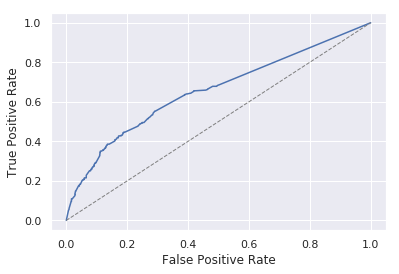

In [59]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(test_y, probabilities[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [61]:
def predict_delay(departure_date_time, origin, destination):
    from datetime import datetime

    try:
        departure_date_time_parsed = datetime.strptime(departure_date_time, '%d/%m/%Y %H:%M:%S')
    except ValueError as e:
        return 'Error parsing date/time - {}'.format(e)

    month = departure_date_time_parsed.month
    day = departure_date_time_parsed.day
    day_of_week = departure_date_time_parsed.isoweekday()
    hour = departure_date_time_parsed.hour

    origin = origin.upper()
    destination = destination.upper()

    input = [{'MONTH': month,
              'DAY': day,
              'DAY_OF_WEEK': day_of_week,
              'CRS_DEP_TIME': hour,
              'ORIGIN_ATL': 1 if origin == 'ATL' else 0,
              'ORIGIN_DTW': 1 if origin == 'DTW' else 0,
              'ORIGIN_JFK': 1 if origin == 'JFK' else 0,
              'ORIGIN_MSP': 1 if origin == 'MSP' else 0,
              'ORIGIN_SEA': 1 if origin == 'SEA' else 0,
              'DEST_ATL': 1 if destination == 'ATL' else 0,
              'DEST_DTW': 1 if destination == 'DTW' else 0,
              'DEST_JFK': 1 if destination == 'JFK' else 0,
              'DEST_MSP': 1 if destination == 'MSP' else 0,
              'DEST_SEA': 1 if destination == 'SEA' else 0 }]

    return model.predict_proba(pd.DataFrame(input))[0][0]

(0.0, 1.0)

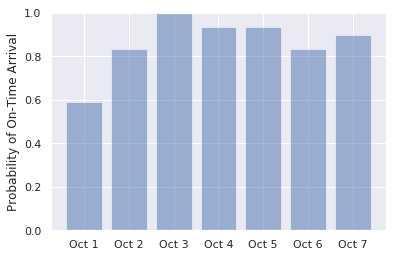

In [65]:
import numpy as np

labels = ('Oct 1', 'Oct 2', 'Oct 3', 'Oct 4', 'Oct 5', 'Oct 6', 'Oct 7')
values = (predict_delay('1/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('2/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('3/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('4/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('5/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('6/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('7/10/2018 21:45:00', 'JFK', 'ATL'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))